### Importing the Libraries


In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import ipywidgets as widgets
from ipywidgets import interact
import scipy.signal as signal
from IPython.display import Audio, display

### Loading the file 

In [ ]:
audio_path = './EE200_practical_programming/song_with_2piccolo.wav'
y, sr = librosa.load(audio_path, sr=None)
print(f"Sample rate: {sr}, Duration: {len(y)/sr:.2f} seconds")

y = y / np.max(np.abs(y))
nyq = 0.5 * sr

Sample rate: 48000, Duration: 15.00 seconds


### Time-Domain Waveform

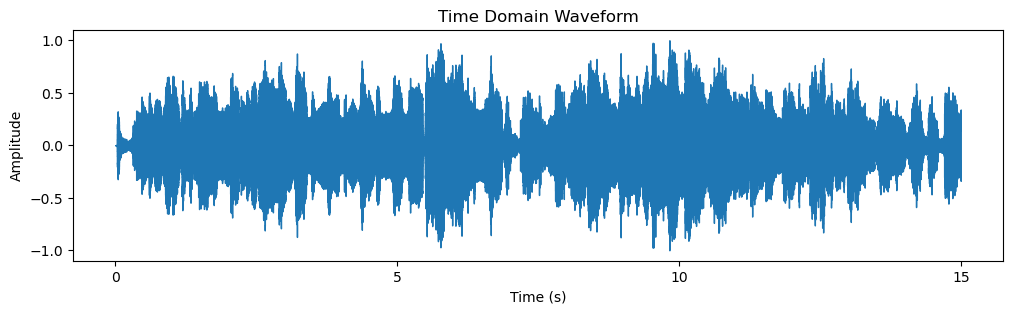

In [3]:
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Time Domain Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

### Fourier Transform 

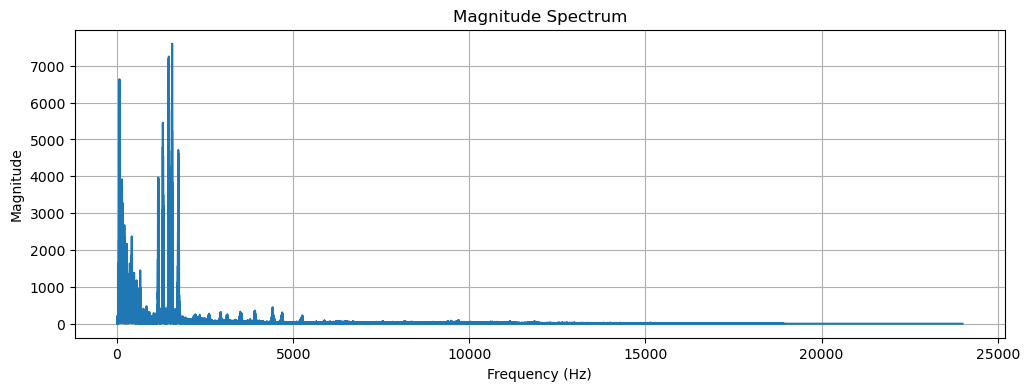

In [4]:
Y = np.fft.fft(y)
frequencies = np.fft.fftfreq(len(Y), d=1/sr)

plt.figure(figsize=(12, 4))
plt.plot(frequencies[:len(frequencies)//2], np.abs(Y)[:len(Y)//2])
plt.title("Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

### Spectrograph

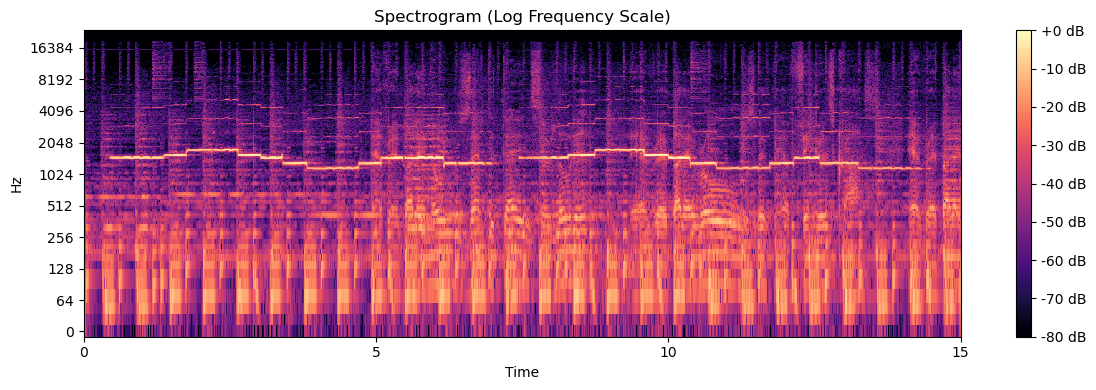

In [5]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (Log Frequency Scale)")
plt.tight_layout()
plt.show()

## Observations from Audio Analysis

### 1. Time-Domain Waveform

- The waveform shows a complex mix of audio components with varying amplitudes over time.
- There are several prominent peaks that suggest the presence of loud, periodic elements, possibly corresponding to an unwanted instrumental solo overlaid on the original music.
- These high-amplitude bursts are spread across the duration of the audio, indicating the interfering signal is persistent.

---

### 2. Frequency Domain (Magnitude Spectrum)

- The magnitude spectrum reveals key frequency bands carrying significant energy:
  - **100–400 Hz**: Dominated by low-frequency components, likely corresponding to bass and lower vocal registers.
  - **Around 1000 Hz**: Additional energy suggests mid-frequency content, possibly harmonics or main vocal presence.
  - **1500–2500 Hz**: A strong, narrow, high-energy band is observed in this range, indicating a dominant, likely unwanted, solo instrumental component.
- The band between **1500 Hz and 2500 Hz** stands out in sharp contrast to the surrounding frequencies and is a prime target for suppression.

---

### 3. Spectrogram Observation

- The spectrogram (on a log frequency scale) visualizes how the audio energy is distributed over time and frequency.
- Most of the signal appears in shades of orange and yellow, indicating **moderate to low energy** across much of the spectrum.
- However, a **consistently bright and isolated horizontal band** is visible in the range of **1024 Hz to 2048 Hz**.
- This band remains active throughout the track and displays **higher intensity** than other frequencies, making it stand out as an **anomalous or intrusive signal**.
- These characteristics—narrow frequency range, persistent presence, and high intensity—indicate the presence of an **unwanted solo instrumental**, making this frequency band ideal for suppression using a **band-stop filter**.

## Designing the filters

Pole-Zero plot function

In [6]:
def plot_pz(b, a):
    z, p, _ = signal.tf2zpk(b, a)
    plt.figure(figsize=(4, 4))
    plt.scatter(np.real(z), np.imag(z), marker='o', label='Zeros')
    plt.scatter(np.real(p), np.imag(p), marker='x', label='Poles')
    plt.title("Pole-Zero Plot")
    plt.xlabel("Re"); plt.ylabel("Im")
    plt.axhline(0, color='gray', lw=0.5); plt.axvline(0, color='gray', lw=0.5)
    unit_circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
    plt.gca().add_artist(unit_circle)
    plt.legend(); plt.grid(True); plt.axis('equal')
    plt.tight_layout()
    plt.show()

### Low-Pass Filter

In [16]:
audio_out = widgets.Output()
plots_out = widgets.Output()

def lowpass_ui_update(method, high_cut, order):
    audio_out.clear_output()
    plots_out.clear_output()

    if method == 'IIR':
        b, a = signal.butter(order, high_cut / nyq, btype='low')
    else:
        b = signal.firwin(numtaps=order*100+1, cutoff=high_cut / nyq, window='blackman')
        a = [1.0]

    y_filt = signal.filtfilt(b, a, y)
    y_filt = y_filt / np.max(np.abs(y_filt))

    with audio_out:
        print("Original Audio:")
        display(Audio(y, rate=sr))
        print("Filtered Audio:")
        display(Audio(y_filt, rate=sr))

    with plots_out:
        w, h = signal.freqz(b, a, worN=2000)
        plt.figure(figsize=(8, 3))
        plt.plot(w * sr / (2*np.pi), 20 * np.log10(abs(h)))
        plt.title(f"{method} Low-Pass Filter Frequency Response")
        plt.xlabel("Frequency (Hz)"); plt.ylabel("Gain (dB)")
        plt.grid(); plt.ylim(-100, 5); plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 2.5))
        plt.plot(y[:sr], label='Original', alpha=0.5)
        plt.plot(y_filt[:sr], label='Filtered', alpha=0.7)
        plt.title("Time-Domain Signal (First 1 sec)")
        plt.xlabel("Samples"); plt.ylabel("Amplitude")
        plt.legend(); plt.grid(); plt.tight_layout()
        plt.show()

        f, Pxx = signal.welch(y_filt, sr, nperseg=1024)
        plt.figure(figsize=(8, 3))
        plt.semilogy(f, Pxx)
        plt.title("Power Spectral Density of Filtered Signal")
        plt.xlabel("Frequency [Hz]"); plt.ylabel("Power")
        plt.grid(True); plt.tight_layout()
        plt.show()

        plot_pz(b, a)

method_widget = widgets.Dropdown(options=["IIR", "FIR"], value="IIR", description="Filter Type")
cutoff_widget = widgets.IntSlider(1000, min=100, max=6000, step=100, description="Cutoff (Hz)")
order_widget = widgets.IntSlider(4, min=1, max=10, description="Order")

widgets.interactive_output(lowpass_ui_update, {
    "method": method_widget,
    "high_cut": cutoff_widget,
    "order": order_widget
})

controls_box = widgets.VBox([method_widget, cutoff_widget, order_widget],
                             layout=widgets.Layout(width='33%', align_items='flex-start'))

audio_box = widgets.VBox([audio_out], layout=widgets.Layout(width='33%', align_items='flex-end'))

top_row = widgets.HBox([controls_box, widgets.Label(" "), audio_box])
final_ui = widgets.VBox([top_row, plots_out])

display(final_ui)

Using Low-Pass Filter remove the noise but the orignal song is also removed as it contains some frequencies greater than the frequencies of noise

For cutoff at 1000Hz it only allows mainly the vocals of the song and no instruments are there in the audio.


Above 1000Hz the noise of piccolo flute is also included in the audio

### High-Pass Filter

In [15]:

highpass_audio_out = widgets.Output()
highpass_plots_out = widgets.Output()

def highpass_ui_update(method, low_cut, order):
    highpass_audio_out.clear_output()
    highpass_plots_out.clear_output()

    if method == 'IIR':
        b, a = signal.butter(order, low_cut / nyq, btype='high')
    else:
        b = signal.firwin(numtaps=order*100+1, cutoff=low_cut / nyq, window='blackman', pass_zero=False)
        a = [1.0]

    y_filt = signal.filtfilt(b, a, y)
    y_filt = y_filt / np.max(np.abs(y_filt))

    with highpass_audio_out:
        print("Original Audio:")
        display(Audio(data=y, rate=sr))
        print("Filtered Audio:")
        display(Audio(data=y_filt, rate=sr))

    with highpass_plots_out:
        w, h = signal.freqz(b, a, worN=2000)
        plt.figure(figsize=(8, 3))
        plt.plot(w * sr / (2*np.pi), 20 * np.log10(abs(h)))
        plt.title(f"{method} High-Pass Filter Response")
        plt.xlabel("Frequency [Hz]"); plt.ylabel("Gain [dB]")
        plt.grid(True); plt.ylim(-100, 5); plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 2.5))
        plt.plot(y[:sr], alpha=0.5, label="Original")
        plt.plot(y_filt[:sr], alpha=0.7, label="Filtered")
        plt.legend(); plt.title("Time-Domain (First 1 sec)"); plt.grid(True); plt.tight_layout()
        plt.show()

        f, Pxx = signal.welch(y_filt, sr, nperseg=1024)
        plt.figure(figsize=(8, 3))
        plt.semilogy(f, Pxx)
        plt.title("Power Spectral Density of Filtered Signal")
        plt.xlabel("Frequency [Hz]"); plt.ylabel("Power")
        plt.grid(True); plt.tight_layout()
        plt.show()
        
        plot_pz(b, a)

hp_method = widgets.Dropdown(options=["IIR", "FIR"], value="IIR", description="Filter Type")
hp_cutoff = widgets.IntSlider(1500, min=100, max=6000, step=100, description="Cutoff (Hz)")
hp_order = widgets.IntSlider(4, min=1, max=10, step=1, description="Order")

widgets.interactive_output(highpass_ui_update, {
    "method": hp_method,
    "low_cut": hp_cutoff,
    "order": hp_order
})
hp_controls_box = widgets.VBox([hp_method, hp_cutoff, hp_order],
                               layout=widgets.Layout(width='33%', align_items='flex-start'))
hp_audio_box = widgets.VBox([highpass_audio_out],
                             layout=widgets.Layout(width='33%', align_items='flex-end'))
hp_top_row = widgets.HBox([hp_controls_box, widgets.Label(" "), hp_audio_box])
hp_final_ui = widgets.VBox([hp_top_row, highpass_plots_out])
display(hp_final_ui)

Using High-Pass filter is not sufficient beacuse human voice are of low frequencies than the noise so if we reove noise then we have to remove the orignal song with the noise

For cutoff at 1500Hz we observe that it only allows the instruments of the song to be in the audio and no vocals which shows that the instruments are of high frequency

### Band-Pass Filter

In [13]:
# --- Output areas ---
bandpass_audio_out = widgets.Output()
bandpass_plots_out = widgets.Output()

# --- Update function for band-pass filter ---
def bandpass_ui_update(method, low_cut, high_cut, order):
    bandpass_audio_out.clear_output()
    bandpass_plots_out.clear_output()

    if low_cut >= high_cut:
        with bandpass_audio_out:
            print("Low cut must be less than high cut.")
        return

    if method == 'IIR':
        b, a = signal.butter(order, [low_cut / nyq, high_cut / nyq], btype='band')
    else:
        b = signal.firwin(numtaps=order*100+1, cutoff=[low_cut / nyq, high_cut / nyq],
                          window='blackman', pass_zero=False)
        a = [1.0]

    y_filt = signal.filtfilt(b, a, y)
    y_filt = y_filt / np.max(np.abs(y_filt))  # Normalize

    with bandpass_audio_out:
        print("Original Audio:")
        display(Audio(data=y, rate=sr))
        print("Filtered Audio:")
        display(Audio(data=y_filt, rate=sr))

    with bandpass_plots_out:
        # Frequency response
        w, h = signal.freqz(b, a, worN=2000)
        plt.figure(figsize=(8, 3))
        plt.plot(w * sr / (2*np.pi), 20 * np.log10(abs(h)))
        plt.title(f"{method} Band-Pass Filter Response")
        plt.xlabel("Frequency [Hz]"); plt.ylabel("Gain [dB]")
        plt.grid(True); plt.ylim(-100, 5); plt.tight_layout()
        plt.show()

        # Time-domain
        plt.figure(figsize=(10, 2.5))
        plt.plot(y[:sr], alpha=0.5, label="Original")
        plt.plot(y_filt[:sr], alpha=0.7, label="Filtered")
        plt.legend(); plt.title("Time-Domain (First 1 sec)"); plt.grid(True); plt.tight_layout()
        plt.show()

        # PSD
        f, Pxx = signal.welch(y_filt, sr, nperseg=1024)
        plt.figure(figsize=(8, 3))
        plt.semilogy(f, Pxx)
        plt.title("Power Spectral Density of Filtered Signal")
        plt.xlabel("Frequency [Hz]"); plt.ylabel("Power")
        plt.grid(True); plt.tight_layout()
        plt.show()

        # Pole-zero
        plot_pz(b, a)

# --- Widgets ---
bp_method = widgets.Dropdown(options=["IIR", "FIR"], value="IIR", description="Filter Type")
bp_low = widgets.IntSlider(1100, min=100, max=5000, step=50, description="Low Cutoff (Hz)")
bp_high = widgets.IntSlider(2500, min=1000, max=6000, step=100, description="High Cutoff (Hz)")
bp_order = widgets.IntSlider(4, min=1, max=10, step=1, description="Order")

# --- Control layout ---
bp_controls_box = widgets.VBox([bp_method, bp_low, bp_high, bp_order],
                               layout=widgets.Layout(width='33%', align_items='flex-start'))

bp_audio_box = widgets.VBox([bandpass_audio_out],
                             layout=widgets.Layout(width='33%', align_items='flex-end'))

bp_top_row = widgets.HBox([bp_controls_box, widgets.Label(" "), bp_audio_box])
bp_final_ui = widgets.VBox([bp_top_row, bandpass_plots_out])

# --- Link logic to widgets (NO DISPLAY HERE!)
widgets.interactive_output(bandpass_ui_update, {
    "method": bp_method,
    "low_cut": bp_low,
    "high_cut": bp_high,
    "order": bp_order
})

# --- Final Display (Only once)
display(bp_final_ui)


If we keep the band between 1200 to 2500 Hz we will only hear the piccolo flute and no other audio is heared so we need to remove this part which we will do by band stop filter.

### Band-Stop Filter

In [21]:
bandstop_audio_out = widgets.Output()
bandstop_plots_out = widgets.Output()

def bandstop_ui_update(method, low_cut, high_cut, order):
    bandstop_audio_out.clear_output()
    bandstop_plots_out.clear_output()

    if low_cut >= high_cut:
        with bandstop_audio_out:
            print("Low cut must be less than high cut.")
        return

    if method == 'IIR':
        b, a = signal.butter(order, [low_cut / nyq, high_cut / nyq], btype='bandstop')
    else:
        b = signal.firwin(numtaps=order*100+1, cutoff=[low_cut / nyq, high_cut / nyq],
                          window='blackman', pass_zero=True)
        a = [1.0]

    y_filt = signal.filtfilt(b, a, y)
    y_filt = y_filt / np.max(np.abs(y_filt))

    with bandstop_audio_out:
        print("Original Audio:")
        display(Audio(data=y, rate=sr))
        print("Filtered Audio:")
        display(Audio(data=y_filt, rate=sr))

    with bandstop_plots_out:
        w, h = signal.freqz(b, a, worN=2000)
        plt.figure(figsize=(8, 3))
        plt.plot(w * sr / (2*np.pi), 20 * np.log10(abs(h)))
        plt.title(f"{method} Band-Stop Filter Response")
        plt.xlabel("Frequency [Hz]"); plt.ylabel("Gain [dB]")
        plt.grid(True); plt.ylim(-100, 5); plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 2.5))
        plt.plot(y[:sr], alpha=0.5, label="Original")
        plt.plot(y_filt[:sr], alpha=0.7, label="Filtered")
        plt.legend(); plt.title("Time-Domain (First 1 sec)"); plt.grid(True); plt.tight_layout()
        plt.show()

        f, Pxx = signal.welch(y_filt, sr, nperseg=1024)
        plt.figure(figsize=(8, 3))
        plt.semilogy(f, Pxx)
        plt.title("Power Spectral Density of Filtered Signal")
        plt.xlabel("Frequency [Hz]"); plt.ylabel("Power")
        plt.grid(True); plt.tight_layout()
        plt.show()
        
        plot_pz(b, a)

bs_method = widgets.Dropdown(options=["IIR", "FIR"], value="IIR", description="Filter Type")
bs_low = widgets.IntSlider(500, min=100, max=5000, step=100, description="Low Cutoff (Hz)")
bs_high = widgets.IntSlider(5500, min=1000, max=16000, step=100, description="High Cutoff (Hz)")
bs_order = widgets.IntSlider(4, min=1, max=10, step=1, description="Order")
widgets.interactive_output(bandstop_ui_update, {
    "method": bs_method,
    "low_cut": bs_low,
    "high_cut": bs_high,
    "order": bs_order
})
bs_controls_box = widgets.VBox([bs_method, bs_low, bs_high, bs_order],
                               layout=widgets.Layout(width='33%', align_items='flex-start'))
bs_audio_box = widgets.VBox([bandstop_audio_out],
                             layout=widgets.Layout(width='33%', align_items='flex-end'))
bs_top_row = widgets.HBox([bs_controls_box, widgets.Label(" "), bs_audio_box])
bs_final_ui = widgets.VBox([bs_top_row, bandstop_plots_out])
display(bs_final_ui)


From the above filter we saw that if we remove the 500-4500Hz part we will get our orignal song with minimum noise 

### From all the above filters we saw that band stop filter works best for our recovery of orignal song

### Special Filter: Removing Band Pass from Orignal

In [22]:
audio_out = widgets.Output()
plots_out = widgets.Output()

def invert_band_ui(method, low_cut, high_cut, order=4):
    audio_out.clear_output()
    plots_out.clear_output()

    if low_cut >= high_cut:
        with plots_out:
            print("⚠️ Low cut must be less than high cut.")
        return

    # Filter design
    if method == 'IIR':
        b, a = signal.butter(order, [low_cut / nyq, high_cut / nyq], btype='band')
    else:
        b = signal.firwin(order * 100 + 1, [low_cut / nyq, high_cut / nyq],
                          window='blackman', pass_zero=False)
        a = [1.0]

    # Apply filter
    y_band = signal.filtfilt(b, a, y)
    y_removed = y - y_band  # Phase-reversed subtraction

    y_band /= np.max(np.abs(y_band))
    y_removed /= np.max(np.abs(y_removed))

    with audio_out:
        print("Original Audio:")
        display(Audio(y, rate=sr))
        print("Band Isolated (to remove):")
        display(Audio(y_band, rate=sr))
        print("After Removing Band (Final Output):")
        display(Audio(y_removed, rate=sr))

    with plots_out:
        w, h = signal.freqz(b, a, worN=2048)
        plt.figure(figsize=(8, 3))
        plt.plot(w * sr / (2*np.pi), 20 * np.log10(abs(h)))
        plt.title(f"{method} Band-Pass Filter Response")
        plt.xlabel("Frequency (Hz)"); plt.ylabel("Gain (dB)")
        plt.grid(True); plt.tight_layout()
        plt.show()

        # Time domain comparison
        plt.figure(figsize=(10, 3))
        plt.plot(y[:sr], label="Original", alpha=0.5)
        plt.plot(y_removed[:sr], label="Band Removed", alpha=0.7)
        plt.legend(); plt.title("Time Domain (1 sec)"); plt.grid(); plt.tight_layout()
        plt.show()

        # PSD
        f, Pxx = signal.welch(y_removed, sr, nperseg=1024)
        plt.figure(figsize=(8, 3))
        plt.semilogy(f, Pxx)
        plt.title("Power Spectral Density (Final Output)")
        plt.xlabel("Frequency [Hz]"); plt.ylabel("Power")
        plt.grid(True); plt.tight_layout()
        plt.show()

# UI Widgets
method_widget = widgets.Dropdown(options=["IIR", "FIR"], value="FIR", description="Filter Type")
low_widget = widgets.IntSlider(500, min=100, max=5000, step=100, description="Low Cutoff (Hz)")
high_widget = widgets.IntSlider(2500, min=500, max=8000, step=100, description="High Cutoff (Hz)")
order_widget = widgets.IntSlider(4, min=1, max=10, description="Order")

controls = widgets.VBox([method_widget, low_widget, high_widget, order_widget])
top_row = widgets.HBox([controls, audio_out])
final_ui = widgets.VBox([top_row, plots_out])

widgets.interactive_output(invert_band_ui, {
    "method": method_widget,
    "low_cut": low_widget,
    "high_cut": high_widget,
    "order": order_widget
})

display(final_ui)


### Analysis of recovered Audio

Sample rate: 48000, Duration: 15.00 seconds


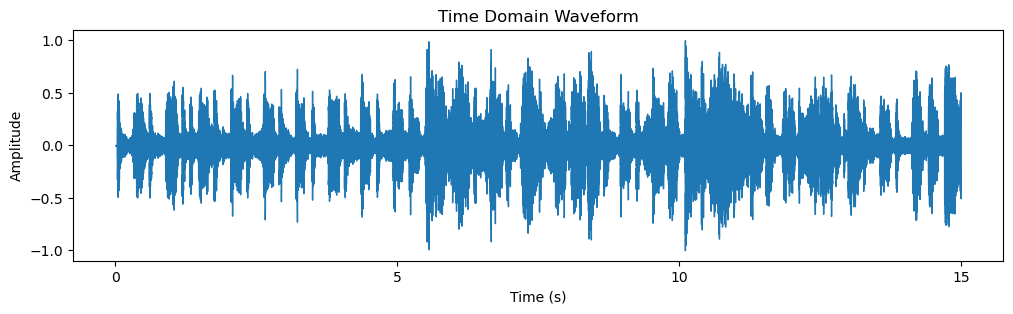

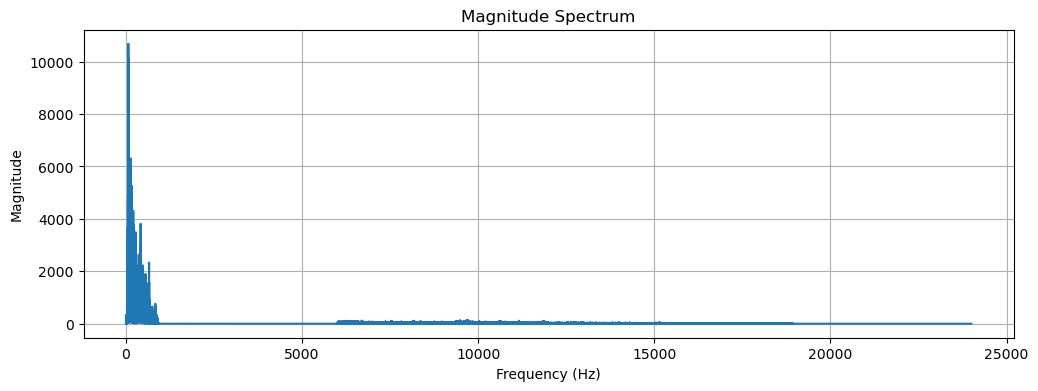

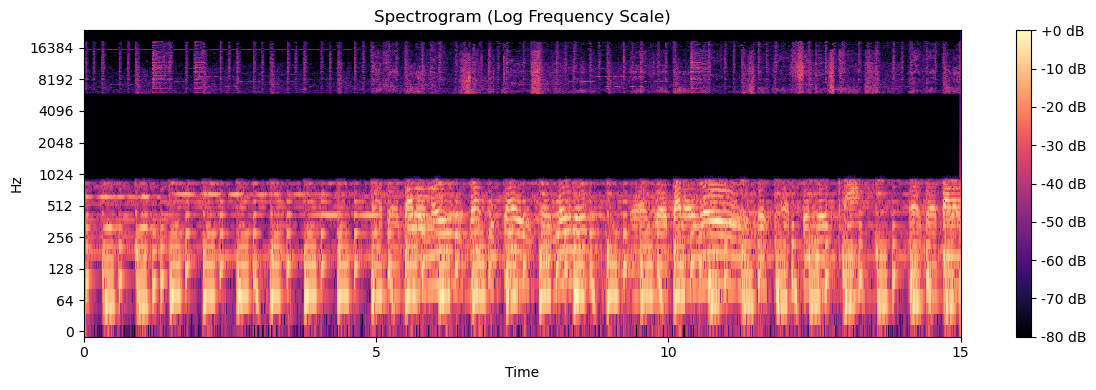

In [25]:
audio_path = './restored_audio.wav' 
y, sr = librosa.load(audio_path, sr=None)
print(f"Sample rate: {sr}, Duration: {len(y)/sr:.2f} seconds")

y = y / np.max(np.abs(y))
nyq = 0.5 * sr

plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Time Domain Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Y = np.fft.fft(y)
frequencies = np.fft.fftfreq(len(Y), d=1/sr)

plt.figure(figsize=(12, 4))
plt.plot(frequencies[:len(frequencies)//2], np.abs(Y)[:len(Y)//2])
plt.title("Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (Log Frequency Scale)")
plt.tight_layout()
plt.show()